In [17]:
# uncomment this if you want to use interactive plot (only works in Jupyter not works in VScode)
# %matplotlib widget

import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp2,run_SLAT_mlp_AGF, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [18]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

In [19]:
adata1 = sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\data\Chen-Stereo_seq-E15.5-s1.h5ad")
adata2 = sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\data\Chen-Stereo_seq-E15.5-s2.h5ad")

In [20]:
import torch


x1_coords=adata1.obsm['spatial'][:,0]
y1_coords=adata1.obsm['spatial'][:,1]
x2_coords=adata2.obsm['spatial'][:,0]
y2_coords=adata2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
location = [locations_1_tensor, locations_2_tensor]

#location
#locations_1_tensor.size(),locations_2_tensor.size()

In [21]:
Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 68008 edges, 6000 cells.
11.334666666666667 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 56646 edges, 5000 cells.
11.3292 neighbors per cell on average.


In [22]:
edges, features = load_anndatas([adata1, adata2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
edges[0]

tensor([[   0,    0,    0,  ..., 5999, 5999, 5999],
        [   0,  207, 1161,  ..., 5700, 5989, 5999]])

In [24]:
location[0].size()

torch.Size([6000, 2])

In [25]:
from scSLAT.model.utils import run_SLAT

embd0, embd1, time = run_SLAT_mlp_AGF(features, edges, location, m=1)

GPU is not available
Running
---------- epochs: 1 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.01 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.02 s ----

Training model time: 14.19


In [26]:
embd2, embd3, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 37.43


In [27]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

true_labels_1 = adata1.obs['annotation'].to_numpy()
true_labels_2 = adata2.obs['annotation'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata1, adata2], reorder=False)

valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_2 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_2)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_2)

print(f'ARI: {ari}, NMI: {nmi}')


ARI: 0.6342621700702837, NMI: 0.6749274731035099


In [28]:
adata1.obsm['scSLAT_bks'] = embd0.detach().cpu().numpy()
adata2.obsm['scSLAT_bks'] = embd1.detach().cpu().numpy()

adata_com=sc.concat([adata1,adata2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com,)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


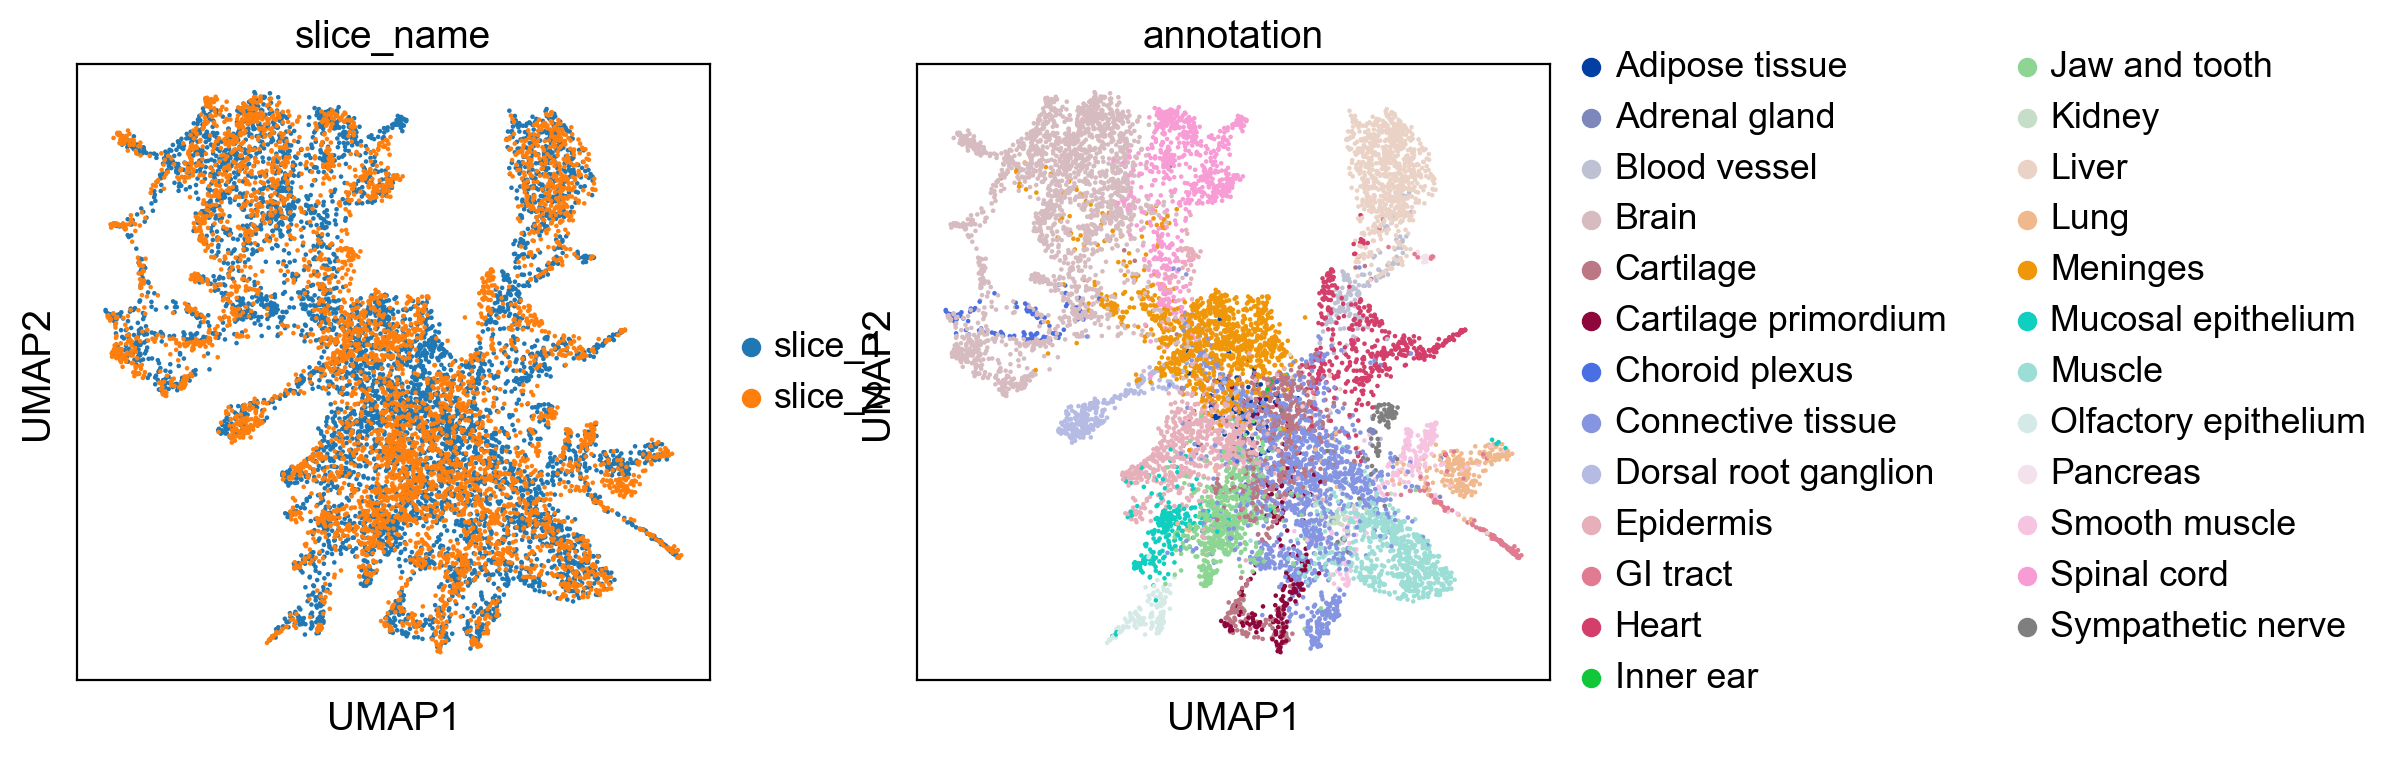

In [29]:
sc.pl.umap(adata_com, color= ['slice_name','annotation'])

In [30]:
true_labels_1 = adata1.obs['annotation'].to_numpy()
true_labels_2 = adata2.obs['annotation'].to_numpy()

best, index, distance = spatial_match([embd2, embd3], adatas=[adata1, adata2], reorder=False)

valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_2 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_2)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_2)

print(f'ARI: {ari}, NMI: {nmi}')


ARI: 0.6282835546329896, NMI: 0.6716351705147472


In [31]:
adata1.obsm['scSLAT_bks'] = embd2.detach().cpu().numpy()
adata2.obsm['scSLAT_bks'] = embd3.detach().cpu().numpy()

adata_com=sc.concat([adata1,adata2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'scSLAT_bks')
sc.tl.umap(adata_com,)

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


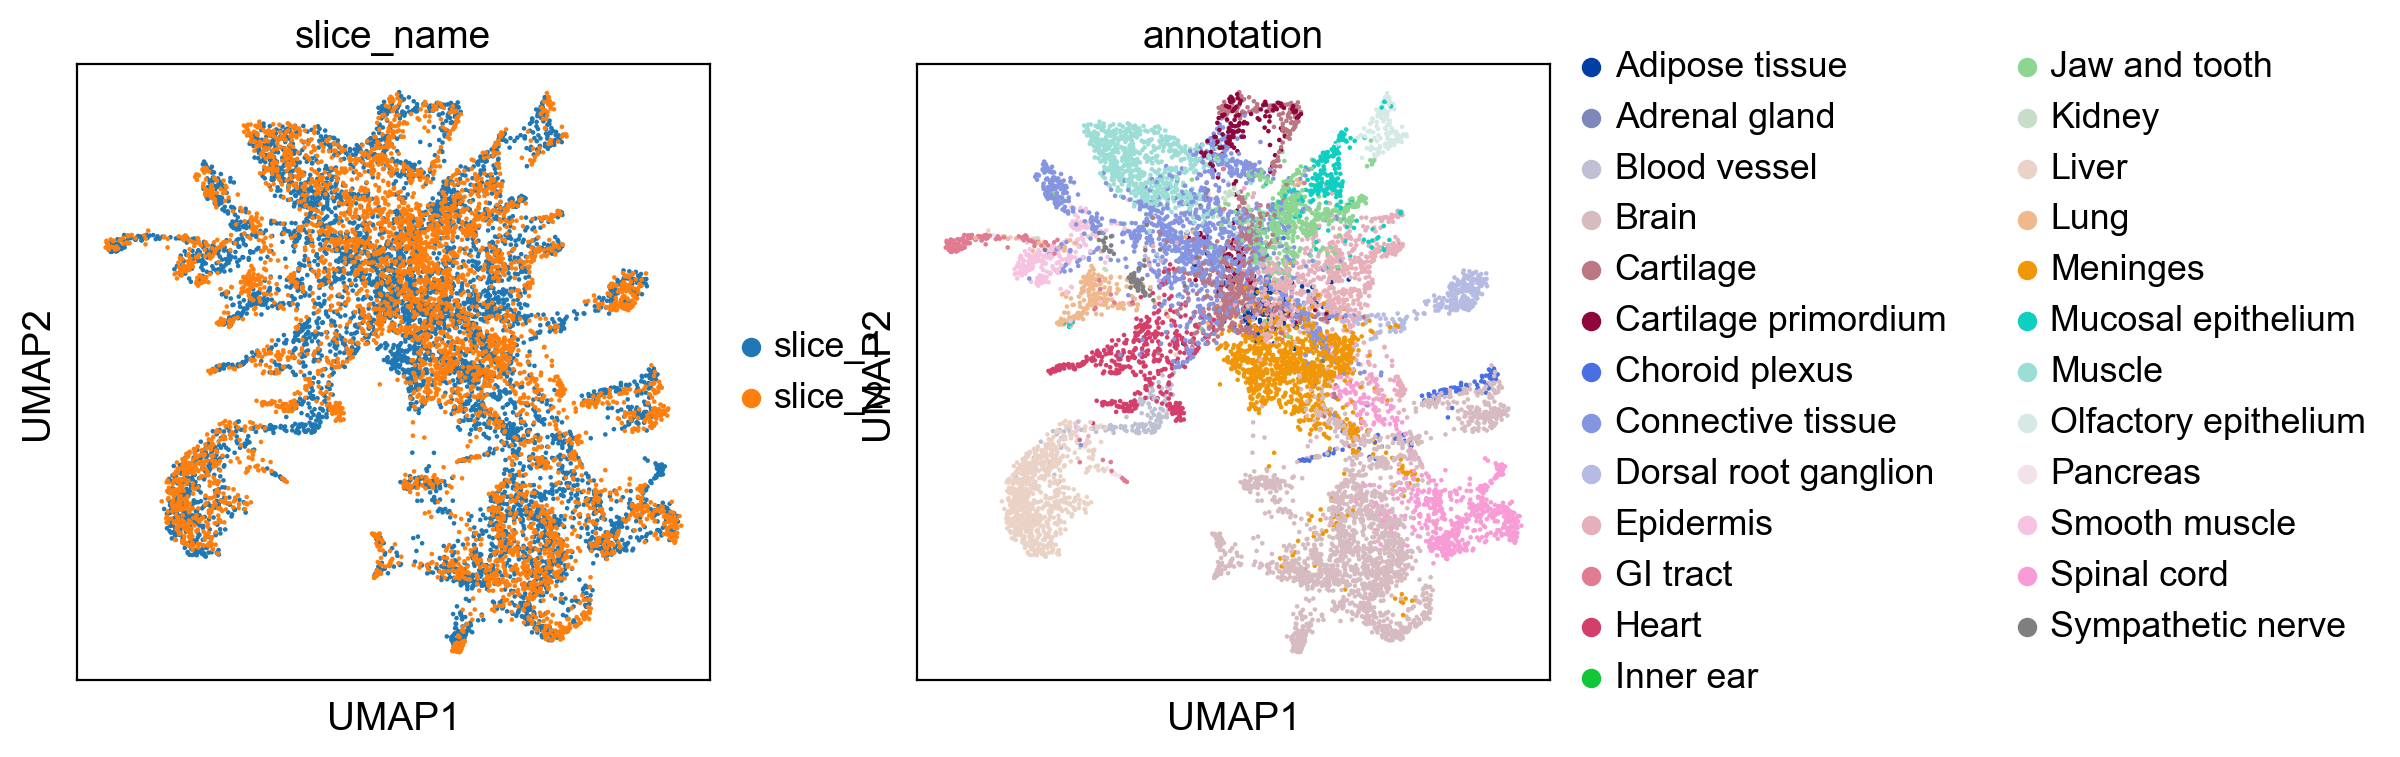

In [32]:
sc.pl.umap(adata_com, color= ['slice_name','annotation'])